# Busienss Objective
The objective is predicting store sales using historical markdown data.
One challenge of modelling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

Each store contains a number of departments, and you are tasked with predicting
the department-wide sales for each store.
In addition, Walmart runs several promotional markdown events throughout the year.
These markdowns precede prominent holidays, the four largest of which are the Super
Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are
weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge
presented by this competition is modelling the effects of markdowns on these holiday
weeks in the absence of complete/ideal historical data.

 stores.csv: This file contains anonymized information about the 45 stores, indicating
the type and size of store.

 train.csv: This is the historical training data, which covers to 2010-02-05 to 2012-11-

1. Within this file you will find the following fields:
     Store - the store number
     Dept - the department number
     Date - the week
     Weekly_Sales - sales for the given department in the given store
     IsHoliday - whether the week is a special holiday week
test.csv: This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

features.csv: This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):
    Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
    Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
    Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
    Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1]:
%%html
<style>
body {
    font-family: "Verdana", cursive, sans-serif;
}
</style> 

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

# Data Importing and Data Preparation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk

# For encoding
from numpy import where as IF

# Text Visualization
from PIL import Image

import random
import os

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse


In [4]:
features = pd.read_csv("../data/features.csv")
stores = pd.read_csv("../data/stores.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [6]:
train['Split'] = 'Train'
test['Split'] = 'Test'

In [7]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Split
0,1,1,2010-02-05,24924.50,False,Train
1,1,1,2010-02-12,46039.49,True,Train
2,1,1,2010-02-19,41595.55,False,Train
3,1,1,2010-02-26,19403.54,False,Train
4,1,1,2010-03-05,21827.90,False,Train


In [10]:
test.head()

,Store,Dept,Date,IsHoliday,Split
0,1,1,2012-11-02,False,Test
1,1,1,2012-11-09,False,Test
2,1,1,2012-11-16,False,Test
3,1,1,2012-11-23,True,Test
4,1,1,2012-11-30,False,Test


In [11]:
print(features.shape)
print(train.shape)
print(test.shape)
print(stores.shape)

(8190, 12)
(421570, 6)
(115064, 5)
(45, 3)


In [12]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Split'], dtype='object')

In [13]:
train.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [14]:
train.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65], dtype=int64)

In [15]:
features.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [16]:
features.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [17]:
len(train)

421570

In [18]:
len(train) + len(test)

536634

In [19]:
df = pd.concat([train,test],axis=0) # Join train and test
print(len(df))
df.tail() # Get an overview of the data

C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


536634


,Date,Dept,IsHoliday,Split,Store,Weekly_Sales
115059,2013-06-28,98,False,Test,45,NaN
115060,2013-07-05,98,False,Test,45,NaN
115061,2013-07-12,98,False,Test,45,NaN
115062,2013-07-19,98,False,Test,45,NaN
115063,2013-07-26,98,False,Test,45,NaN


In [150]:
df = pd.merge(left=df,right=features, how="left", on=['Store','Date','IsHoliday'])
df = pd.merge(left=df,right=stores, how='left',on=['Store'])

In [151]:
df.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,2010-02-05,1,False,Train,1,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,2010-02-12,1,True,Train,1,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,2010-02-19,1,False,Train,1,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,2010-02-26,1,False,Train,1,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,2010-03-05,1,False,Train,1,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [152]:
len(df.Date.unique())

182

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 17 columns):
Date            536634 non-null object
Dept            536634 non-null int64
IsHoliday       536634 non-null bool
Split           536634 non-null object
Store           536634 non-null int64
Weekly_Sales    421570 non-null float64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       265596 non-null float64
MarkDown2       197685 non-null float64
MarkDown3       242326 non-null float64
MarkDown4       237143 non-null float64
MarkDown5       266496 non-null float64
CPI             498472 non-null float64
Unemployment    498472 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
dtypes: bool(1), float64(10), int64(3), object(3)
memory usage: 70.1+ MB


In [154]:
df['Date'] = pd.to_datetime(df['Date'])

In [155]:
df.describe()

,Dept,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,536634.000000,536634.000000,421570.000000,536634.000000,536634.000000,265596.000000,197685.000000,242326.000000,237143.000000,266496.000000,498472.000000,498472.000000,536634.000000
mean,44.277301,22.208621,15981.258123,58.771762,3.408310,7438.004144,3509.274827,1857.913525,3371.556866,4324.021158,172.090481,7.791888,136678.550960
std,30.527358,12.790580,22711.183519,18.678716,0.430861,9411.341379,8992.047197,11616.143274,6872.281734,13549.262124,39.542149,1.865076,61007.711799
min,1.000000,1.000000,-4988.940000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000
25%,18.000000,11.000000,2079.650000,45.250000,3.041000,2114.640000,72.500000,7.220000,336.240000,1570.112500,132.521867,6.623000,93638.000000
50%,37.000000,22.000000,7612.030000,60.060000,3.523000,5126.540000,385.310000,40.760000,1239.040000,2870.910000,182.442420,7.795000,140167.000000
75%,74.000000,33.000000,20205.852500,73.230000,3.744000,9303.850000,2392.390000,174.260000,3397.080000,5012.220000,213.748126,8.549000,202505.000000
max,99.000000,45.000000,693099.360000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000


In [156]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9

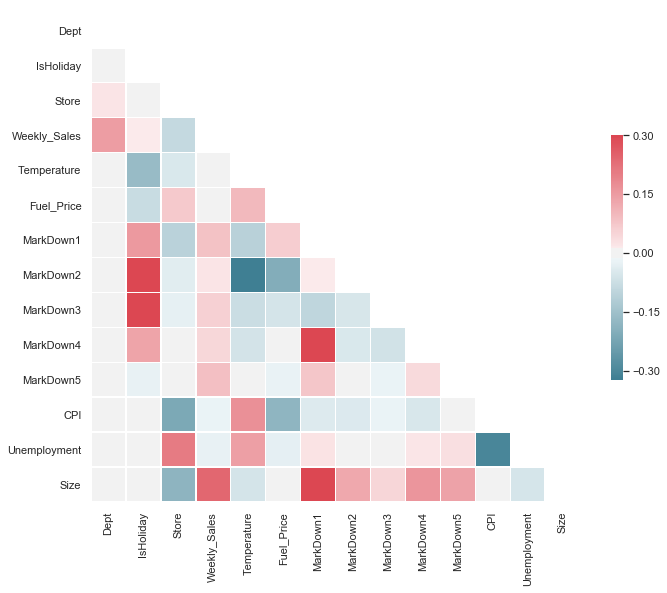

In [157]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [158]:
def scatterplots(feature, label):
    x = feature
    y = df['Weekly_Sales']
    plt.scatter(x, y)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

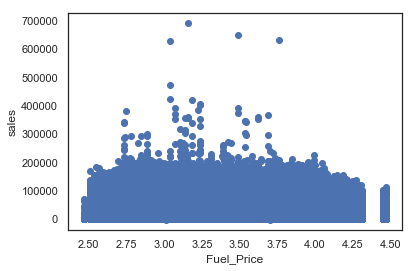

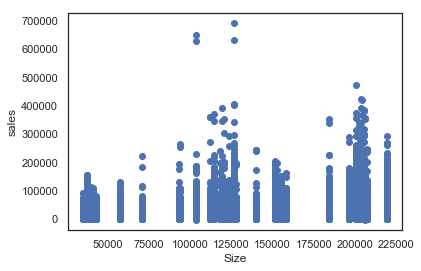

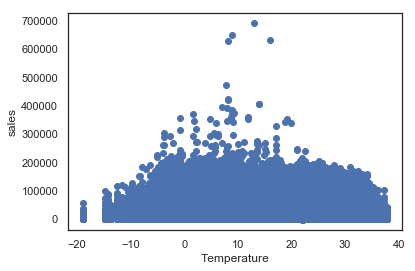

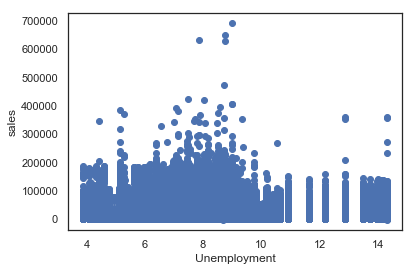

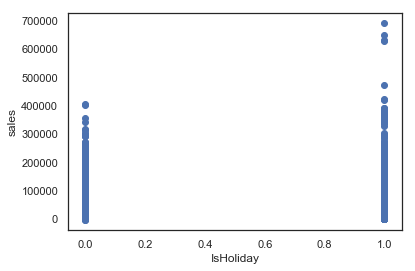

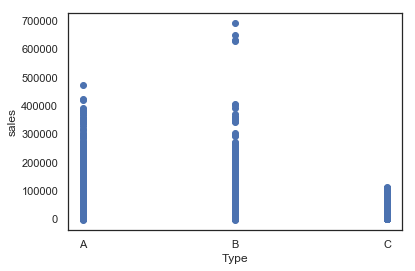

In [117]:
%matplotlib inline
# features = ['Fuel_Price','Size','Temperature','Unemployment','IsHoliday','Type']
# y = df['Weekly_Sales']
# # headers = list(df)
# # labels = headers
# plt.figure(figsize=(10,15))
# for i, j in enumerate(features):
#     plt.subplot(3,2,i+1)
#     plt.scatter(df[j],y)
#     plt.ylabel('sales')
#     plt.show()
    
scatterplots(df['Fuel_Price'], 'Fuel_Price')
scatterplots(df['Size'],'Size')
scatterplots(df['Temperature'], 'Temperature')
scatterplots(df['Unemployment'], 'Unemployment')
scatterplots(df['IsHoliday'], 'IsHoliday')
scatterplots(df['Type'], 'Type')

In [118]:
df.loc[df['Weekly_Sales'] >300000]

,Date,Dept,IsHoliday,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
30474,2011-12-23,7,False,4,318422.01,2.177778,3.103,2461.94,69.05,2938.24,52.00,4396.76,129.984548,5.143,A,205863
37201,2010-11-26,72,True,4,381072.11,8.933333,2.752,NaN,NaN,NaN,NaN,NaN,126.669267,7.127,A,205863
37253,2011-11-25,72,True,4,385051.04,8.866667,3.225,561.45,137.88,83340.33,44.04,9239.23,129.836400,5.143,A,205863
56417,2010-11-26,72,True,6,342578.65,18.772222,2.735,NaN,NaN,NaN,NaN,NaN,213.267296,7.007,A,202505
56469,2011-11-25,72,True,6,326866.60,17.100000,3.236,429.03,171.88,83192.81,15.00,986.23,220.041741,6.551,A,202505
88428,2010-12-24,7,False,10,406988.63,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512
88480,2011-12-23,7,False,10,341308.00,9.088889,3.541,300.02,77.73,2432.01,108.37,4078.21,129.984548,7.874,B,126512
95373,2010-11-26,72,True,10,693099.36,12.961111,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512
95377,2010-12-24,72,False,10,404245.03,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512
95425,2011-11-25,72,True,10,630999.19,15.933333,3.760,174.72,329.00,141630.61,79.00,1009.98,129.836400,7.874,B,126512


It appears to be quite obvious. The end of November sees a lot of exceptionally large sales. This special day, better known as Black friday, causes sales to be on fire, and undoubtedly a dummy variable should be created for this day. Also, Christmas, appears here and there. Since it is not considered holiday, we will also make a dummy for this day. Let's see if we should consider some other special days as well.

In [159]:
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2011-08-26     1
2010-02-05     1
Name: Date, dtype: int64

In [160]:
df.isnull().sum()

Date                 0
Dept                 0
IsHoliday            0
Split                0
Store                0
Weekly_Sales    115064
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
Type                 0
Size                 0
dtype: int64

In [161]:
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

In [162]:
df

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Type,Size,md1_present,md2_present,md3_present,md4_present,md5_present
0,2010-02-05,1,False,Train,1,24924.50,5.727778,2.572,NaN,NaN,...,NaN,211.096358,8.106,A,151315,False,False,False,False,False
1,2010-02-12,1,True,Train,1,46039.49,3.616667,2.548,NaN,NaN,...,NaN,211.242170,8.106,A,151315,False,False,False,False,False
2,2010-02-19,1,False,Train,1,41595.55,4.405556,2.514,NaN,NaN,...,NaN,211.289143,8.106,A,151315,False,False,False,False,False
3,2010-02-26,1,False,Train,1,19403.54,8.127778,2.561,NaN,NaN,...,NaN,211.319643,8.106,A,151315,False,False,False,False,False
4,2010-03-05,1,False,Train,1,21827.90,8.055556,2.625,NaN,NaN,...,NaN,211.350143,8.106,A,151315,False,False,False,False,False
5,2010-03-12,1,False,Train,1,21043.39,14.327778,2.667,NaN,NaN,...,NaN,211.380643,8.106,A,151315,False,False,False,False,False
6,2010-03-19,1,False,Train,1,22136.64,12.544444,2.720,NaN,NaN,...,NaN,211.215635,8.106,A,151315,False,False,False,False,False
7,2010-03-26,1,False,Train,1,26229.21,10.805556,2.732,NaN,NaN,...,NaN,211.018042,8.106,A,151315,False,False,False,False,False
8,2010-04-02,1,False,Train,1,57258.43,16.816667,2.719,NaN,NaN,...,NaN,210.820450,7.808,A,151315,False,False,False,False,False
9,2010-04-09,1,False,Train,1,42960.91,18.811111,2.770,NaN,NaN,...,NaN,210.622857,7.808,A,151315,False,False,False,False,False


In [163]:
# Make sure we can later recognize what a dummy once belonged to
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [164]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

### Dummy variables: Dates

From our earlier analysis, it has turned out that the date may be our best friend. As a general rule, it is a good start to already distinguish between different months in our model. This will create 12 dummy variables; one for each month.

In [165]:
# df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = df['Date'].dt.month
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

Next, let's look at 'special dates'. One variable for Christmas, one for black friday. We have to manually look up the dates of black friday if we want to extrapolate our data to other years, but for now we know: 26 - 11 - 2010 and 25 - 11 - 2011.

In [166]:
df['Black_Friday'] = np.where((df['Date']==datetime(2010, 11, 26).date()) | (df['Date']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['Date']==datetime(2010, 12, 23).date()) | (df['Date']==datetime(2010, 12, 24).date()) | (df['Date']==datetime(2011, 12, 23).date()) | (df['Date']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )

C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  


In [167]:
df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

In [168]:
# Get dataframe with averages per store and department
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,Month_1,IsHoliday_False,17350.585
1,Type_A,Dept_1,Store_1,Month_10,IsHoliday_False,23388.030
2,Type_A,Dept_1,Store_1,Month_11,IsHoliday_False,19551.115
3,Type_A,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,Month_12,IsHoliday_False,39109.390


In [169]:
# Merge by type, store, department and month
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])


In [170]:
# Fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 

# Create a key for easy access

df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)


In [171]:
df.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,2010-02-05,Dept_1,IsHoliday_False,Train,Store_1,24924.50,5.727778,2.572,NaN,NaN,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05 00:00:00IsHolida...
1,2010-02-19,Dept_1,IsHoliday_False,Train,Store_1,41595.55,4.405556,2.514,NaN,NaN,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19 00:00:00IsHolida...
2,2010-02-26,Dept_1,IsHoliday_False,Train,Store_1,19403.54,8.127778,2.561,NaN,NaN,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26 00:00:00IsHolida...
3,2011-02-04,Dept_1,IsHoliday_False,Train,Store_1,21665.76,5.705556,2.989,NaN,NaN,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04 00:00:00IsHolida...
4,2011-02-18,Dept_1,IsHoliday_False,Train,Store_1,46845.87,14.088889,3.045,NaN,NaN,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18 00:00:00IsHolida...


### Lagged Variables

We will take a lagged variable of our store's previous weeks sales. To do so, we will first add a column with a one week lagged date, sort the data, and then match the lagged sales with the initial dataframe using the department and store number.

We begin by adding a column with a one week lag.

In [172]:
from datetime import timedelta
# Attach variable of last weeks time
df['DateLagged'] = df['Date']- timedelta(days=7)
df.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,2010-02-05,Dept_1,IsHoliday_False,Train,Store_1,24924.50,5.727778,2.572,NaN,NaN,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05 00:00:00IsHolida...,2010-01-29
1,2010-02-19,Dept_1,IsHoliday_False,Train,Store_1,41595.55,4.405556,2.514,NaN,NaN,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19 00:00:00IsHolida...,2010-02-12
2,2010-02-26,Dept_1,IsHoliday_False,Train,Store_1,19403.54,8.127778,2.561,NaN,NaN,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26 00:00:00IsHolida...,2010-02-19
3,2011-02-04,Dept_1,IsHoliday_False,Train,Store_1,21665.76,5.705556,2.989,NaN,NaN,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04 00:00:00IsHolida...,2011-01-28
4,2011-02-18,Dept_1,IsHoliday_False,Train,Store_1,46845.87,14.088889,3.045,NaN,NaN,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18 00:00:00IsHolida...,2011-02-11


Next, we create a sorted dataframe.

In [173]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','Date'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

Loop over its rows and check at each step if the previous week's sales are available. If not, fill with store and department average, which we retrieved before.

In [174]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['Date']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\anaconda3old\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [175]:
sorted_df[['Dept', 'Store','Date','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,Date,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-12,24924.50,46039.49,37887.17
2,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
3,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,21280.40


Now, merge this new info with our existing dataset.

In [176]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','Date','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','Date'])

In [177]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['Dept', 'Store','Date','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,Date,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
2,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
3,Dept_1,Store_1,2011-02-04,18461.18,21665.76,23510.49
4,Dept_1,Store_1,2011-02-18,37887.17,46845.87,23510.49


### Remove redundant items

We will take the store average in the available data as one of its properties

In [178]:
switch= 1

if(switch):
    df_backup = df
else:
    df=df_backup
    display(df_backup.head())

### Scale Variables

To make the job of our models easier in the next phase, we normalize our continous data. This is also called feature scaling.

In [179]:
df['Unemployment'] = (df['Unemployment'] - df['Unemployment'].mean())/(df['Unemployment'].std())
df['Temperature'] = (df['Temperature'] - df['Temperature'].mean())/(df['Temperature'].std())
df['Fuel_Price'] = (df['Fuel_Price'] - df['Fuel_Price'].mean())/(df['Fuel_Price'].std())
df['CPI'] = (df['CPI'] - df['CPI'].mean())/(df['CPI'].std())
df['MarkDown1'] = (df['MarkDown1'] - df['MarkDown1'].mean())/(df['MarkDown1'].std())
df['MarkDown2'] = (df['MarkDown2'] - df['MarkDown2'].mean())/(df['MarkDown2'].std())
df['MarkDown3'] = (df['MarkDown3'] - df['MarkDown3'].mean())/(df['MarkDown3'].std())
df['MarkDown4'] = (df['MarkDown4'] - df['MarkDown4'].mean())/(df['MarkDown4'].std())
df['MarkDown5'] = (df['MarkDown5'] - df['MarkDown5'].mean())/(df['MarkDown5'].std())
df['LaggedSales']= (df['LaggedSales'] - df['LaggedSales'].mean())/(df['LaggedSales'].std())

Now, let's change the variable to be forecasted to the difference from the median. Afterward, we can drop the weekly sales.

In [180]:
df['Difference'] = df['Median Sales'] - df['Weekly_Sales']

Let's have a look at our data set before running our actual models.

In [181]:
df.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,2010-02-05,Dept_1,IsHoliday_False,Train,Store_1,24924.50,-0.881311,-1.941019,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-05 00:00:00IsHolida...,2010-01-29,0.332347,0.0,0.00,-1414.01
1,2010-02-19,Dept_1,IsHoliday_False,Train,Store_1,41595.55,-1.008729,-2.075633,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-19 00:00:00IsHolida...,2010-02-12,1.325278,1.0,-22529.00,-18085.06
2,2010-02-26,Dept_1,IsHoliday_False,Train,Store_1,19403.54,-0.650032,-1.966549,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-26 00:00:00IsHolida...,2010-02-19,1.129418,1.0,-18085.06,4106.95
3,2011-02-04,Dept_1,IsHoliday_False,Train,Store_1,21665.76,-0.883453,-0.973190,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-04 00:00:00IsHolida...,2011-01-28,0.109806,1.0,5049.31,1844.73
4,2011-02-18,Dept_1,IsHoliday_False,Train,Store_1,46845.87,-0.075581,-0.843218,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-18 00:00:00IsHolida...,2011-02-11,0.965977,1.0,-14376.68,-23335.38


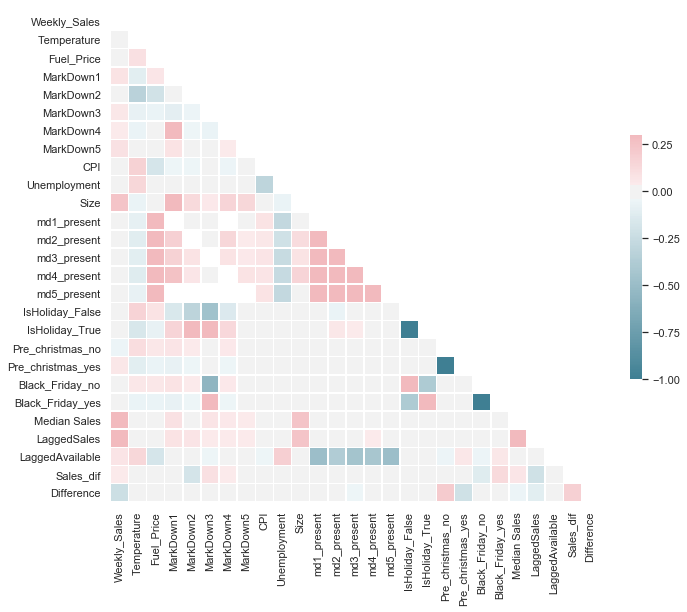

In [182]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Exploratory Data Analysis

In [185]:
df.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,2010-02-05,Dept_1,IsHoliday_False,Train,Store_1,24924.50,-0.881311,-1.941019,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-05 00:00:00IsHolida...,2010-01-29,0.332347,0.0,0.00,-1414.01
1,2010-02-19,Dept_1,IsHoliday_False,Train,Store_1,41595.55,-1.008729,-2.075633,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-19 00:00:00IsHolida...,2010-02-12,1.325278,1.0,-22529.00,-18085.06
2,2010-02-26,Dept_1,IsHoliday_False,Train,Store_1,19403.54,-0.650032,-1.966549,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-26 00:00:00IsHolida...,2010-02-19,1.129418,1.0,-18085.06,4106.95
3,2011-02-04,Dept_1,IsHoliday_False,Train,Store_1,21665.76,-0.883453,-0.973190,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-04 00:00:00IsHolida...,2011-01-28,0.109806,1.0,5049.31,1844.73
4,2011-02-18,Dept_1,IsHoliday_False,Train,Store_1,46845.87,-0.075581,-0.843218,NaN,NaN,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-18 00:00:00IsHolida...,2011-02-11,0.965977,1.0,-14376.68,-23335.38


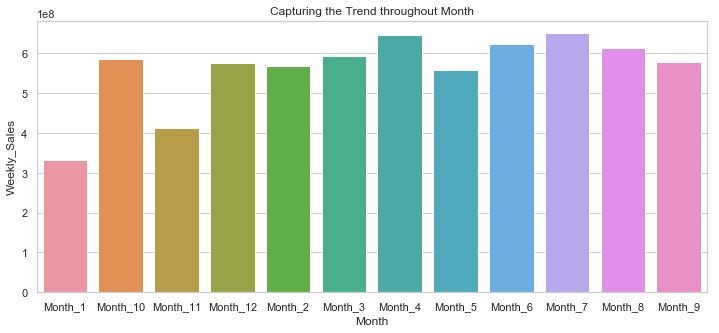

In [194]:
plt.figure(figsize=(12,5))
graph = train.groupby('Month')[['Weekly_Sales']].sum().reset_index()
sns.set_style("whitegrid")
ax = sns.barplot(x='Month',y='Weekly_Sales',data=graph).set_title("Capturing the Trend throughout Month")


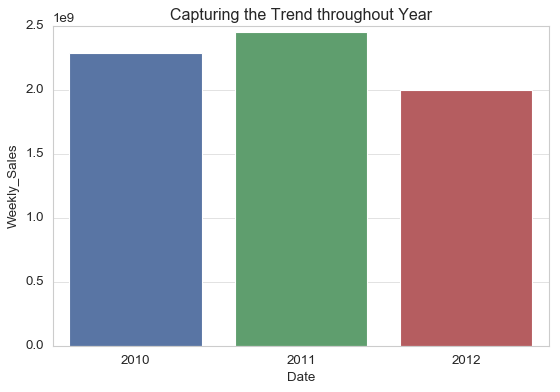

In [231]:
plt.figure(figsize=(8,5))
graph = train.groupby(train.Date.dt.year)[['Weekly_Sales']].sum().reset_index()
sns.set_style("whitegrid")
ax = sns.barplot(x='Date',y='Weekly_Sales',data=graph).set_title("Capturing the Trend throughout Year")


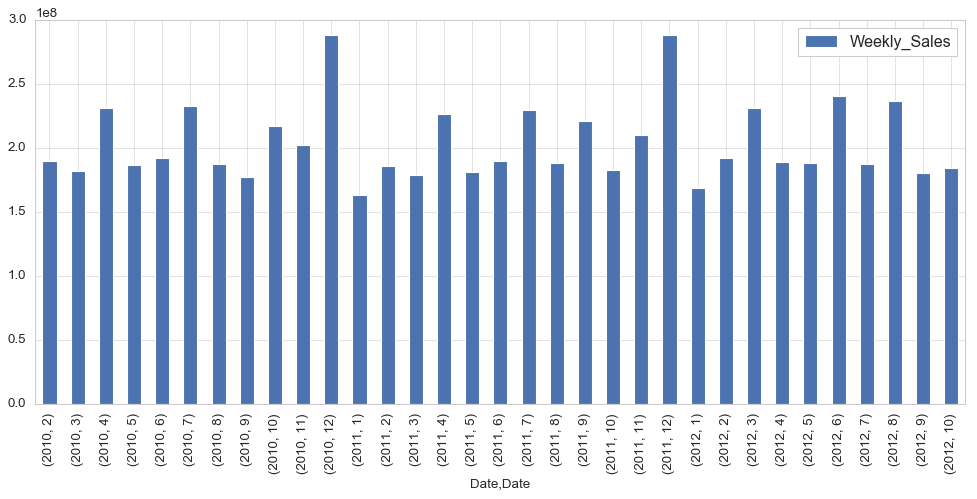

In [272]:
train.groupby([train['Date'].dt.year,train['Date'].dt.month])[['Weekly_Sales']].sum().plot(kind='bar',figsize=(15,6))

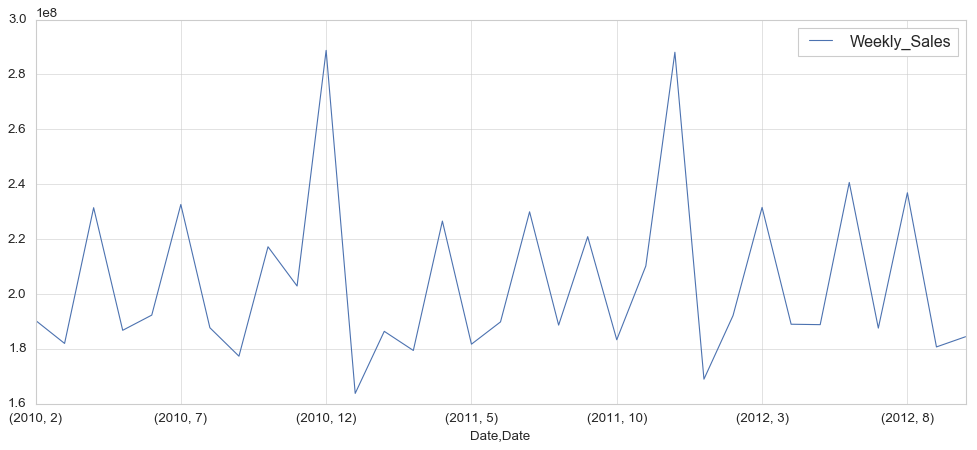

In [273]:
train.groupby([train['Date'].dt.year,train['Date'].dt.month])[['Weekly_Sales']].sum().plot(kind='line',figsize=(15,6))

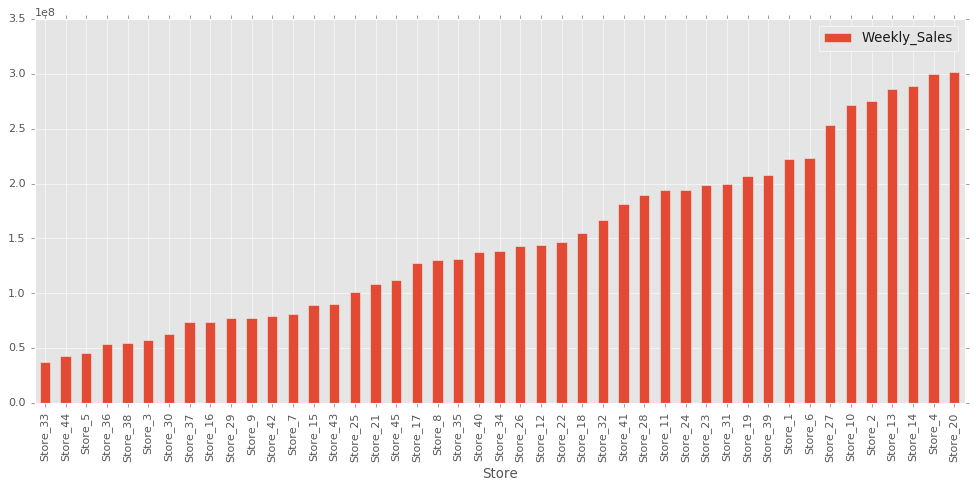

In [223]:
with plt.style.context(('ggplot')):
    train.groupby([train.Store])[['Weekly_Sales']].sum().sort_values('Weekly_Sales').plot(kind='bar',figsize=(15,6))
plt.show()

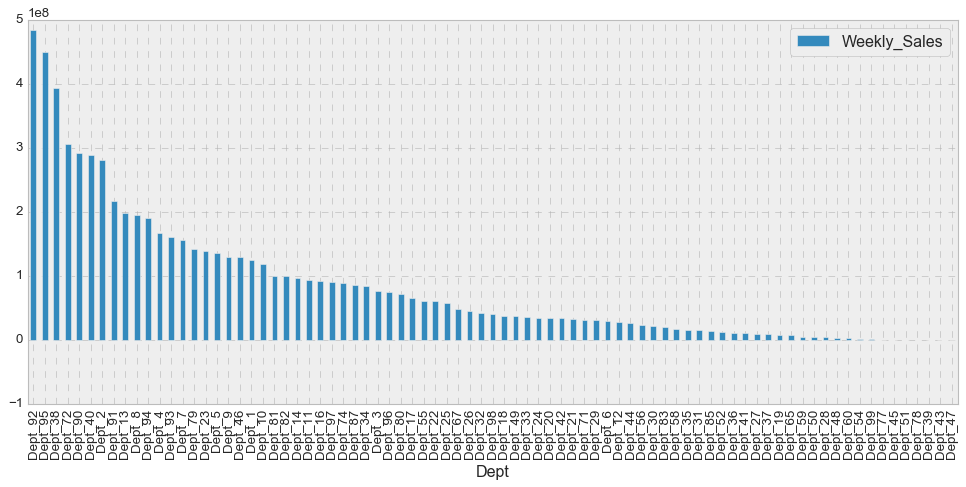

In [238]:
with plt.style.context(('bmh')):
    train.groupby(train.Dept)[['Weekly_Sales']].sum().sort_values('Weekly_Sales', ascending=False).plot(kind='bar',figsize=(15,6))
plt.show()

Text(0.5, 1.0, '          Weekly_Sales in Holiday ')

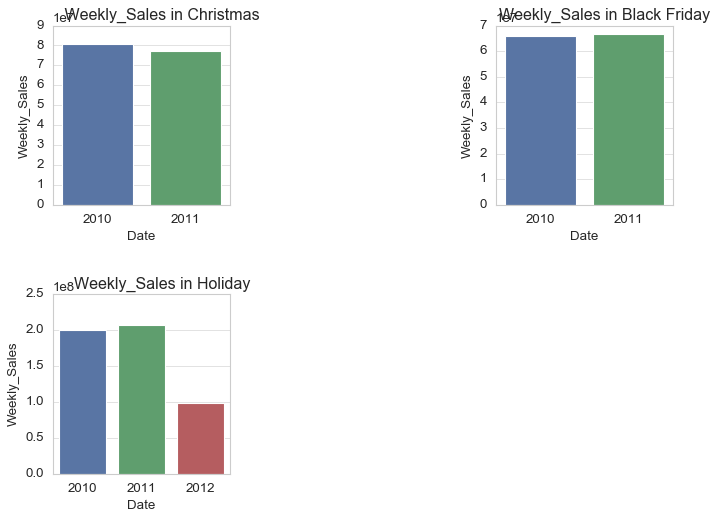

In [269]:
plt.subplots(figsize=(10,7))
plt.subplots_adjust(wspace = 1.5,hspace=0.5)
plt.subplot(2, 2, 1)
graph = train[train.Pre_christmas == 'Pre_christmas_yes'].groupby([train.Date.dt.year])[['Weekly_Sales']].sum().reset_index()
sns.barplot(y='Weekly_Sales',x='Date',data=graph)
plt.title("         Weekly_Sales in Christmas")

plt.subplot(2, 2, 2)
# plt.subplots_adjust(wspace = 1,hspace=0.5)
graph = train[train.Black_Friday == 'Black_Friday_yes'].groupby([train.Date.dt.year])[['Weekly_Sales']].sum().reset_index()
sns.barplot(y='Weekly_Sales',x='Date',data=graph)
plt.title("          Weekly_Sales in Black Friday ")

plt.subplot(2, 2, 3)
# plt.subplots_adjust(wspace = 1,hspace=0.5)
graph =train[train.IsHoliday == 'IsHoliday_True'].groupby([train.Date.dt.year])[['Weekly_Sales']].sum().reset_index()
sns.barplot(y='Weekly_Sales',x='Date',data=graph)
plt.title("          Weekly_Sales in Holiday ")


### Select variables to include in model

In this section, we can change the variables we ultimately want to include in our model training. 

In [183]:
selector = [
    #'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
   
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,4.984720e+05,5.366340e+05,2.655960e+05,1.976850e+05,2.423260e+05,2.371430e+05,2.664960e+05,536634.000000,5.366340e+05,4.984720e+05,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,5.366340e+05,536634.000000,536634.000000
mean,-1.795847e-13,1.115326e-12,1.363936e-13,7.454670e-15,-5.806345e-15,-4.110242e-14,-2.236551e-14,136678.550960,-2.602841e-13,-1.731762e-12,0.928091,0.071909,0.988851,0.011149,0.988896,0.011104,-1.842216e-14,-195.362035,0.773412
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,61007.711799,1.000000e+00,1.000000e+00,0.258338,0.258338,0.104999,0.104999,0.104791,0.104791,1.000000e+00,6003.550792,0.418624
min,-1.163985e+00,-2.173112e+00,-1.085866e+00,-4.198193e-01,-1.753743e-01,-4.905702e-01,-3.327998e-01,34875.000000,-3.536740e+00,-2.202532e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.809701e-01,-540263.085000,0.000000
25%,-1.000669e+00,-8.525016e-01,-5.656329e-01,-3.822016e-01,-1.593208e-01,-4.416753e-01,-2.032516e-01,93638.000000,-7.239128e-01,-6.267244e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-6.111607e-01,-302.140000,1.000000
50%,2.617951e-01,2.661879e-01,-2.456041e-01,-3.474142e-01,-1.564335e-01,-3.103070e-01,-1.072465e-01,140167.000000,6.896823e-02,1.668320e-03,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-3.685166e-01,0.000000,1.000000
75%,1.053500e+00,7.791140e-01,1.982550e-01,-1.242081e-01,-1.449408e-01,3.713924e-03,5.079235e-02,202505.000000,7.740488e-01,4.059414e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.856780e-01,279.820000,1.000000
max,1.438616e+00,2.459469e+00,1.017357e+01,1.123329e+01,1.270864e+01,9.327803e+00,5.661741e+01,219622.000000,2.311628e+00,3.496432e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.984344e+01,579251.325000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,0.986438,-1.941019,NaN,NaN,NaN,NaN,NaN,151315,-0.881311,0.168418,...,False,1,0,1,0,1,0,0.332347,0.00,0.0
1,0.991313,-2.075633,NaN,NaN,NaN,NaN,NaN,151315,-1.008729,0.168418,...,False,1,0,1,0,1,0,1.325278,-22529.00,1.0
2,0.992085,-1.966549,NaN,NaN,NaN,NaN,NaN,151315,-0.650032,0.168418,...,False,1,0,1,0,1,0,1.129418,-18085.06,1.0
3,1.023627,-0.973190,NaN,NaN,NaN,NaN,NaN,151315,-0.883453,-0.026749,...,False,1,0,1,0,1,0,0.109806,5049.31,1.0
4,1.040849,-0.843218,NaN,NaN,NaN,NaN,NaN,151315,-0.075581,-0.026749,...,False,1,0,1,0,1,0,0.965977,-14376.68,1.0


### Split data into training and test sets

Now we can split train test again and of course remove the trivial weekly sales data from the test set.

In [277]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
# train = train[selector]
# test = test[selector]
test.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
9,2013-02-01,Dept_1,IsHoliday_False,Test,Store_1,NaN,-0.123765,-0.381352,0.196880,-0.239031,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-01 00:00:00IsHolida...,2013-01-25,0.332347,0.0,0.0,NaN
10,2013-02-15,Dept_1,IsHoliday_False,Test,Store_1,NaN,-0.487815,0.154783,6.959612,0.351004,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-15 00:00:00IsHolida...,2013-02-08,0.332347,0.0,0.0,NaN
11,2013-02-22,Dept_1,IsHoliday_False,Test,Store_1,NaN,-0.456228,0.437937,1.346221,-0.038410,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-22 00:00:00IsHolida...,2013-02-15,0.332347,0.0,0.0,NaN
15,2013-02-08,Dept_1,IsHoliday_True,Test,Store_1,NaN,-0.112522,0.020169,2.647567,-0.309104,...,0,1,0,37887.17,Type_ADept_1Store_12013-02-08 00:00:00IsHolida...,2013-02-01,0.965977,0.0,0.0,NaN
29,2013-03-01,Dept_1,IsHoliday_False,Test,Store_1,NaN,-0.576151,0.702523,0.337118,-0.361187,...,0,1,0,21280.40,Type_ADept_1Store_12013-03-01 00:00:00IsHolida...,2013-02-22,0.234059,0.0,0.0,NaN


In [290]:
train.fillna(0,inplace=True)
# train.isnull().sum()

In [291]:
train.isnull().sum()

Date                 0
Dept                 0
IsHoliday            0
Split                0
Store                0
Weekly_Sales         0
Temperature          0
Fuel_Price           0
MarkDown1            0
MarkDown2            0
MarkDown3            0
MarkDown4            0
MarkDown5            0
CPI                  0
Unemployment         0
Type                 0
Size                 0
md1_present          0
md2_present          0
md3_present          0
md4_present          0
md5_present          0
Month                0
Black_Friday         0
Pre_christmas        0
IsHoliday_False      0
IsHoliday_True       0
Pre_christmas_no     0
Pre_christmas_yes    0
Black_Friday_no      0
Black_Friday_yes     0
Median Sales         0
Key                  0
DateLagged           0
LaggedSales          0
LaggedAvailable      0
Sales_dif            0
Difference           0
dtype: int64

In [218]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


### Test - dev

Usually, model performance can be evaluated on the out-of-sample test set. However, since that data is not available, it may be wise to split our training set one more time in order to be able to test out of sample performance. Let's give up 20% of our training set for this sanity check development set.

In [292]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(84314, 24)
(84314,)


### Random Forest

Train on random forest

In [293]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Random forest model specification
regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

### Model evaluation
 
 To evaluate the model, we will look at MAE and accuracy in terms of the number of times it correctly estimated an upward or downward deviation from the median.


In [294]:
y_pred_random = regr.predict(X_dev)
y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.5s finished


In [299]:
# y_dev

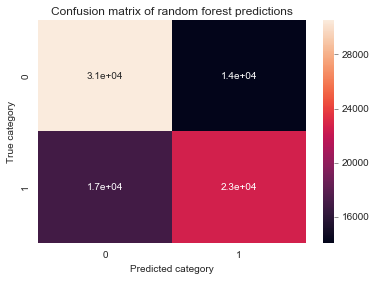

In [301]:
def binary(movement):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    direction = np.empty(movement.shape[0])
    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax,  annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [302]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,Date,Dept,IsHoliday,Split,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
2,2010-02-26,Dept_1,IsHoliday_False,Train,Store_1,19403.54,-0.650032,-1.966549,0.000000,0.000000,...,1,0,23510.49,Type_ADept_1Store_12010-02-26 00:00:00IsHolida...,2010-02-19,1.129418,1.0,-18085.06,4106.95,-4290.60650
7,2012-02-17,Dept_1,IsHoliday_False,Train,Store_1,54060.10,-0.720165,0.236016,0.258765,0.839964,...,1,0,23510.49,Type_ADept_1Store_12012-02-17 00:00:00IsHolida...,2012-02-10,0.926369,1.0,-13478.00,-30549.61,-16812.02250
14,2012-02-10,Dept_1,IsHoliday_True,Train,Store_1,36988.49,-0.575616,0.001602,0.689281,0.380109,...,1,0,37887.17,Type_ADept_1Store_12012-02-10 00:00:00IsHolida...,2012-02-03,0.332347,1.0,14376.68,898.68,-1695.56575
28,2012-03-30,Dept_1,IsHoliday_False,Train,Store_1,28952.86,0.473172,1.013528,0.305119,-0.390209,...,1,0,21280.40,Type_ADept_1Store_12012-03-30 00:00:00IsHolida...,2012-03-23,0.270521,1.0,-827.30,-7672.46,-308.11950
39,2011-04-01,Dept_1,IsHoliday_False,Train,Store_1,20398.09,0.021320,0.268509,0.000000,0.000000,...,1,0,26318.08,Type_ADept_1Store_12011-04-01 00:00:00IsHolida...,2011-03-25,0.216461,1.0,5436.98,5919.99,-260.39275


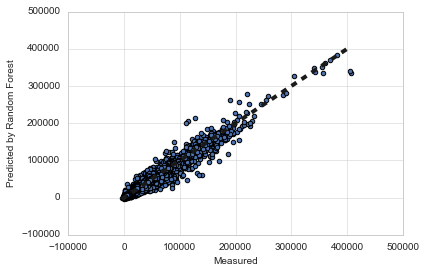

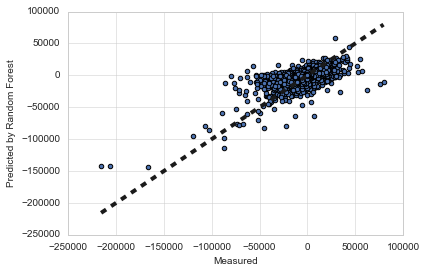

In [307]:
def plot_prediction(true,predicted,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()

df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_dev['Difference'].values,y_pred_random,"Random Forest")

In [308]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1545.7406070759525
Random Forest: 1346.5835426945673


Looks good! Let's train on our full data set to get the maximum amount of information in our model.

In [309]:
#Random forest model specification. Set n_estimators lower for faster performance
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

KeyboardInterrupt: 

In [ ]:
#Use if large model skipped
#rf_model = regr

## Forecasting sales

After we have created our model, we can predict things with it on the test set

In [ ]:
final_y_prediction = rf_model.predict(test[selector])

In [ ]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

# Store and Department wise Sales Prediction

In [5]:
features = pd.read_csv("../data/features.csv")
stores = pd.read_csv("../data/stores.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [6]:
print(list(train.Store.unique()))
print(list(train.Dept.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65]


In [7]:
store_11 = train[(train.Store == 1) & (train.Dept == 1)][['Date','Weekly_Sales','IsHoliday']]
store_11.head()

,Date,Weekly_Sales,IsHoliday
0,2010-02-05,24924.50,False
1,2010-02-12,46039.49,True
2,2010-02-19,41595.55,False
3,2010-02-26,19403.54,False
4,2010-03-05,21827.90,False


In [8]:
# store_11 = 
test[(test.Store == 1) & (test.Dept == 1)]#[['Date','IsHoliday']]


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
5,1,1,2012-12-07,False
6,1,1,2012-12-14,False
7,1,1,2012-12-21,False
8,1,1,2012-12-28,True
9,1,1,2013-01-04,False


In [9]:
store_11.shape

(143, 3)

In [10]:
store_11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 3 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
IsHoliday       143 non-null bool
dtypes: bool(1), float64(1), object(1)
memory usage: 3.5+ KB


In [11]:
store_11['Date'] = pd.to_datetime(store_11.Date)
store_11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 3 columns):
Date            143 non-null datetime64[ns]
Weekly_Sales    143 non-null float64
IsHoliday       143 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [12]:
store_11 = store_11.sort_values('Date')#.set_index('Date')
store_11.head()

,Date,Weekly_Sales,IsHoliday
0,2010-02-05,24924.50,False
1,2010-02-12,46039.49,True
2,2010-02-19,41595.55,False
3,2010-02-26,19403.54,False
4,2010-03-05,21827.90,False


In [13]:
# Creating seperate column for months and year
from datetime import datetime
import calendar
store_11['Month'] = store_11['Date'].dt.month
# store_11['Month'] = store_11['Month'].apply(lambda x: calendar.month_abbr[x])
store_11['Year'] = store_11.Date.dt.year

In [14]:
store_11.head()

,Date,Weekly_Sales,IsHoliday,Month,Year
0,2010-02-05,24924.50,False,2,2010
1,2010-02-12,46039.49,True,2,2010
2,2010-02-19,41595.55,False,2,2010
3,2010-02-26,19403.54,False,2,2010
4,2010-03-05,21827.90,False,3,2010


In [15]:
store_11 = store_11.set_index('Date')
store_11.head()

,Weekly_Sales,IsHoliday,Month,Year
Date,,,,
2010-02-05,24924.50,False,2,2010
2010-02-12,46039.49,True,2,2010
2010-02-19,41595.55,False,2,2010
2010-02-26,19403.54,False,2,2010
2010-03-05,21827.90,False,3,2010


# Exploratory Data Analysis

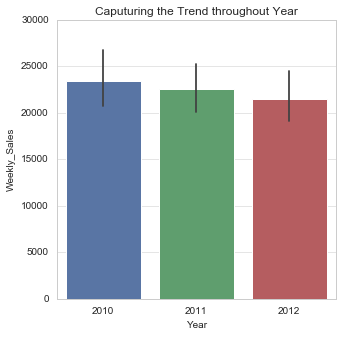

In [345]:
import seaborn as sns
plt.figure(figsize=(5,5))
graph = pd.DataFrame()
graph['Weekly_Sales'] = store_11['Weekly_Sales']
graph['Year'] = store_11.Year
sns.set_style("whitegrid")
ax = sns.barplot(x="Year", y="Weekly_Sales", data=graph).set_title("Caputuring the Trend throughout Year")

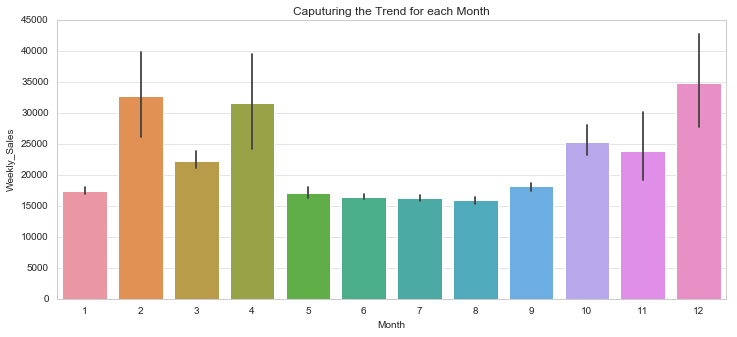

In [346]:
plt.figure(figsize=(12,5))
graph = pd.DataFrame()
graph['Weekly_Sales'] = store_11['Weekly_Sales']
graph['Month'] = store_11.Month
sns.set_style("whitegrid")
ax = sns.barplot(x="Month", y="Weekly_Sales", data=graph).set_title("Caputuring the Trend for each Month")

In [355]:
store_11.head()

,Weekly_Sales,IsHoliday,Month,Year
Date,,,,
2010-02-05,24924.50,False,2,2010
2010-02-12,46039.49,True,2,2010
2010-02-19,41595.55,False,2,2010
2010-02-26,19403.54,False,2,2010
2010-03-05,21827.90,False,3,2010


In [16]:
# Extract out just time series data
store_11_ts = store_11['Weekly_Sales']
store_11_ts.head()

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
Name: Weekly_Sales, dtype: float64

In [17]:
store_11_ts.rolling(window=4).mean().head()

Date
2010-02-05         NaN
2010-02-12         NaN
2010-02-19         NaN
2010-02-26    32990.77
2010-03-05    32216.62
Name: Weekly_Sales, dtype: float64

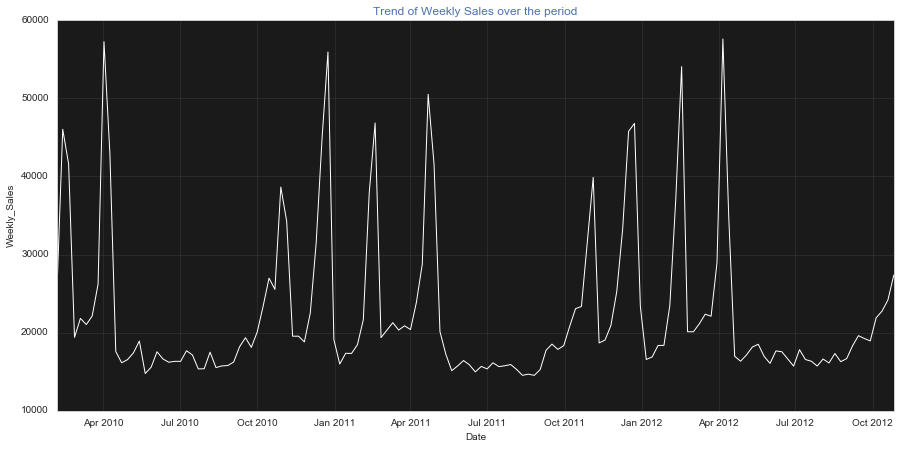

In [366]:
# Checking trend using lineplot
att1 = store_11#.groupby('Month')[['Weekly_Sales']].sum().reset_index()
plt.figure(figsize=(15,7))
ax = sns.lineplot(att1.index,att1["Weekly_Sales"],color="w")
ax.set_facecolor("k")
plt.grid(True,color="grey",alpha=.3)
plt.title("Trend of Weekly Sales over the period",color='b')
plt.show()

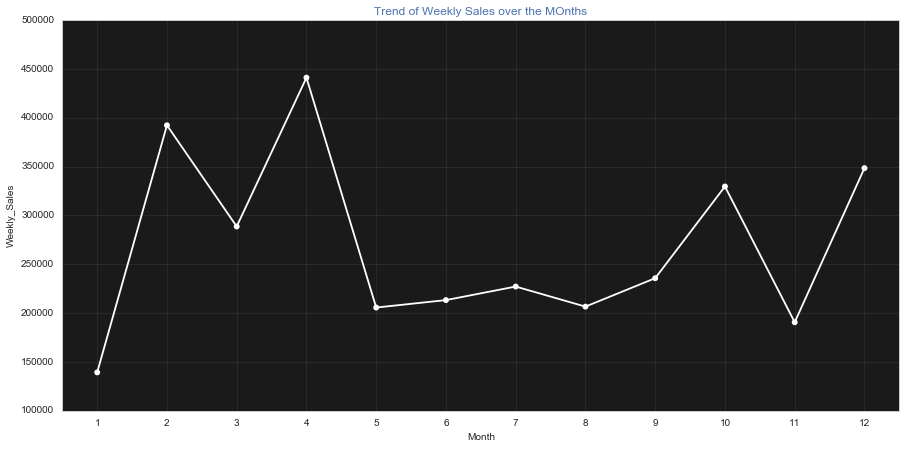

In [367]:
# Checking trend using lineplot
att1 = store_11.groupby('Month')[['Weekly_Sales']].sum().reset_index()
plt.figure(figsize=(15,7))
ax = sns.pointplot(att1["Month"],att1["Weekly_Sales"],color="w")
ax.set_facecolor("k")
plt.grid(True,color="grey",alpha=.3)
plt.title("Trend of Weekly Sales over the MOnths",color='b')
plt.show()


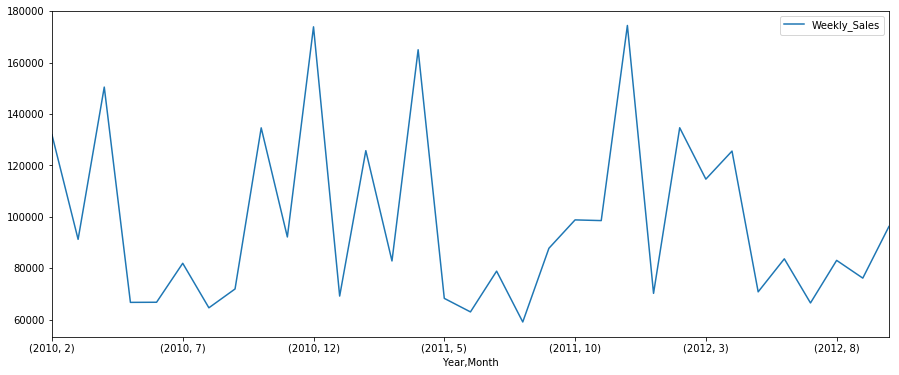

In [34]:
store_11.groupby(['Year','Month'])[['Weekly_Sales']].sum().plot(kind='line',figsize=(15,6))

In [35]:
store_11_ts.head()

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
Name: Weekly_Sales, dtype: float64

In [368]:
store_11_ts.rolling(window=4).mean().head()

Date
2010-02-05         NaN
2010-02-12         NaN
2010-02-19         NaN
2010-02-26    32990.77
2010-03-05    32216.62
Name: Weekly_Sales, dtype: float64

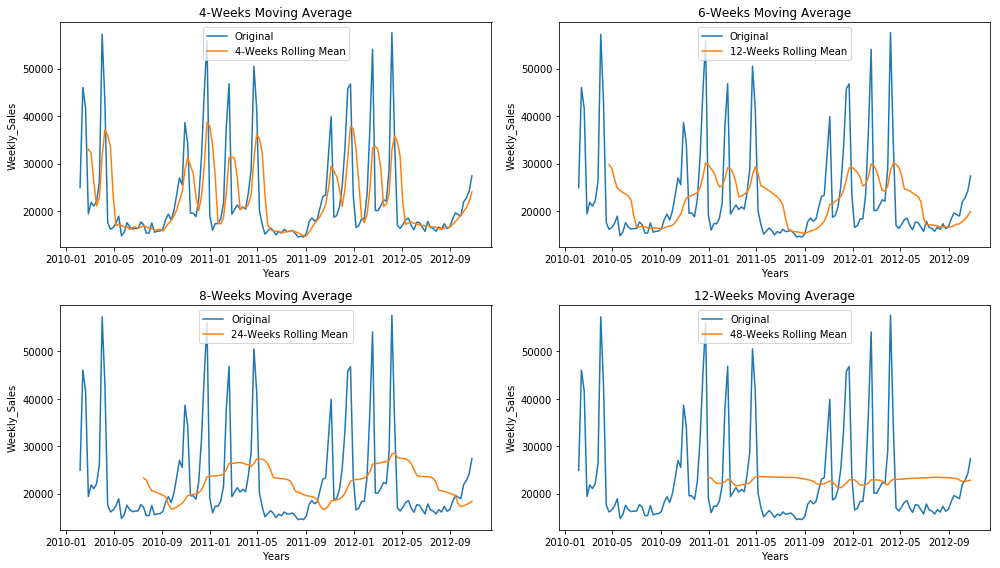

In [36]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(store_11_ts.index, store_11_ts, label='Original')
axes[0][0].plot(store_11_ts.index, store_11_ts.rolling(window=4).mean(), label='4-Weeks Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Weekly_Sales")
axes[0][0].set_title("4-Weeks Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(store_11_ts.index, store_11_ts, label='Original')
axes[0][1].plot(store_11_ts.index, store_11_ts.rolling(window=12).mean(), label='12-Weeks Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Weekly_Sales")
axes[0][1].set_title("6-Weeks Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(store_11_ts.index, store_11_ts, label='Original')
axes[1][0].plot(store_11_ts.index, store_11_ts.rolling(window=24).mean(), label='24-Weeks Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Weekly_Sales")
axes[1][0].set_title("8-Weeks Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(store_11_ts.index, store_11_ts, label='Original')
axes[1][1].plot(store_11_ts.index, store_11_ts.rolling(window=48).mean(), label='48-Weeks Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Weekly_Sales")
axes[1][1].set_title("12-Weeks Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

#### Step 1.2: Seasonality – Time Series Decomposition

The first thing to do is to see how Weekly Sales vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [376]:
monthly_store_11 = pd.pivot_table(store_11, values = "Weekly_Sales", columns = "Year", index = "Month")
# monthly_store_11 = monthly_store_11.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_store_11

Year,2010,2011,2012
Month,,,
1,NaN,17286.6475,17551.3375
2,32990.7700,31440.6575,33670.8250
3,22809.2850,20705.8350,22936.1080
4,30103.3520,33011.3900,31400.0300
5,16673.5375,17062.9300,17698.2450
6,16685.1750,15744.6425,16729.3080
7,16383.0020,15771.2460,16617.1975
8,16144.7025,14765.4875,16609.1140
9,17978.3175,17551.2820,19034.4750


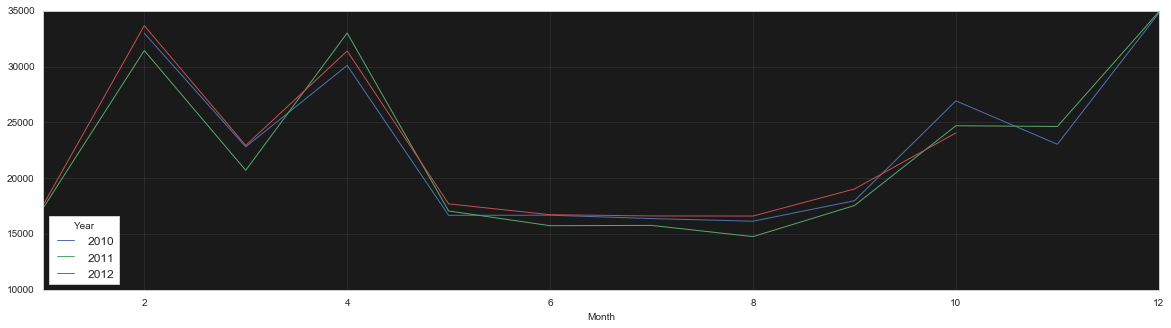

In [382]:
ax = monthly_store_11.plot(figsize=(20,5))
ax.set_facecolor("k")
plt.grid(True,color="grey",alpha=.3)

In [394]:
yearly_store_11 = pd.pivot_table(store_11, values = "Weekly_Sales", columns = "Month", index = "Year")
# yearly_store_11 = yearly_store_11[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_store_11

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,32990.7700,22809.285,30103.352,16673.5375,16685.1750,16383.0020,16144.7025,17978.3175,26928.9060,23040.3500,34796.776
2011,17286.6475,31440.6575,20705.835,33011.390,17062.9300,15744.6425,15771.2460,14765.4875,17551.2820,24701.7075,24634.3775,34902.414
2012,17551.3375,33670.8250,22936.108,31400.030,17698.2450,16729.3080,16617.1975,16609.1140,19034.4750,24061.1400,NaN,NaN


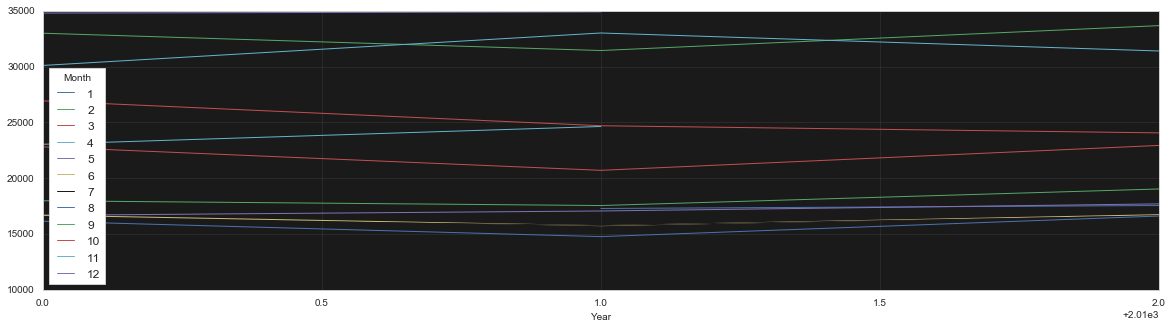

In [383]:
ax = yearly_store_11.plot(figsize=(20,5))
ax.set_facecolor("k")
plt.grid(True,color="grey",alpha=.3)

In [395]:
# yearly_store_11.boxplot(figsize=(20,10))


#### Step 1.3: Irregular Remainder – Time Series Decomposition
To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model with the following equation:

- Yt=Trendt×Seasonalityt×Remaindert
 
Instead of multiplicative model we could have chosen additive model as well. In that case the equaltion would have been:

- Yt=Trendt+Seasonalityt+Remaindert
 
However, it would have made very little difference in terms of conclusion we will draw from this time series decomposition exercise. Additionally, we are also aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

In [37]:
#import statsmodesls.api as sm
import statsmodels.tsa.api as smt
import statsmodels as sm
decomposition1 = sm.tsa.seasonal.seasonal_decompose(store_11_ts, model='multiplicative', two_sided=False, extrapolate_trend=4)
decomposition2 = sm.tsa.seasonal.seasonal_decompose(store_11_ts, model='additive', two_sided=False, extrapolate_trend=4)


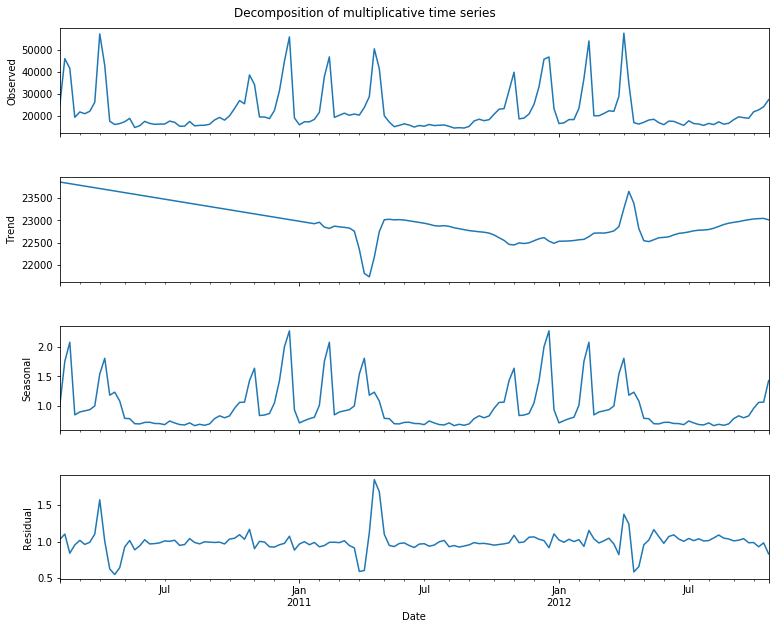

In [38]:
fig = decomposition1.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

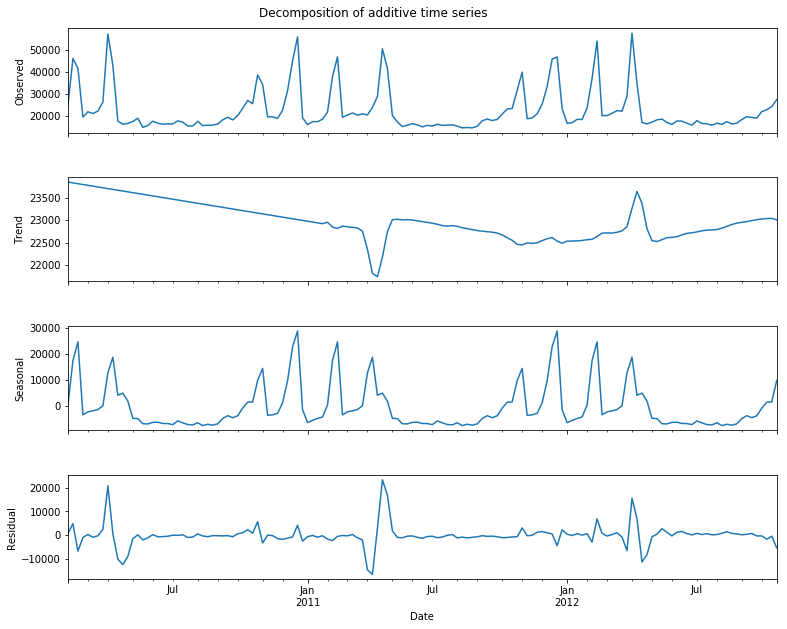

In [39]:
fig = decomposition2.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle('Decomposition of additive time series')
plt.show()

In [43]:
decomp_output1 = pd.DataFrame(pd.concat([decomposition1.observed, decomposition1.trend, decomposition1.seasonal, decomposition1.resid], axis=1))

#or

decomp_output2 = pd.DataFrame(pd.concat([decomposition2.observed, decomposition2.trend, decomposition2.seasonal, decomposition2.resid], axis=1))

In [44]:
decomp_output1.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']
decomp_output2.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [45]:
decomp_output1['TSI'] = decomp_output1.Trend*decomp_output1.Seasonal*decomp_output1.Irregular
decomp_output2['TSI'] = decomp_output2.Trend+decomp_output2.Seasonal+decomp_output2.Irregular

In [46]:
display(decomp_output1.head())
display(decomp_output2.head())

,observed,Trend,Seasonal,Irregular,TSI
Date,,,,,
2010-02-05,24924.50,23856.827519,1.016519,1.027775,24924.50
2010-02-12,46039.49,23838.581087,1.753724,1.101257,46039.49
2010-02-19,41595.55,23820.334654,2.075511,0.841345,41595.55
2010-02-26,19403.54,23802.088221,0.854697,0.953792,19403.54
2010-03-05,21827.90,23783.841788,0.903197,1.016126,21827.90


,observed,Trend,Seasonal,Irregular,TSI
Date,,,,,
2010-02-05,24924.50,23856.827519,397.310518,670.361963,24924.50
2010-02-12,46039.49,23838.581087,17375.067694,4825.841219,46039.49
2010-02-19,41595.55,23820.334654,24565.665640,-6790.450294,41595.55
2010-02-26,19403.54,23802.088221,-3340.489235,-1058.058986,19403.54
2010-03-05,21827.90,23783.841788,-2205.570584,249.628796,21827.90


### Forecasting using decomposition with the help of STLDECOMPOSE PACKAGE

In [47]:
from stldecompose import decompose, forecast 
from stldecompose.forecast_funcs import (naive,drift,mean,seasonal_naive)  

#### Decomposition

In [37]:
decompose?

One of the primary pieces of functionality is the STL decomposition. The associated method requires the observation frame, and the primary (largest) period of seasonality. This period is specified in terms of index positions, and so care is needed for the user to correctly specify the periodicity in terms of their observations.

For example, with daily observations and large annual cycles, period=365. For hourly observations with large daily cycles, period=24. Some inspection, and trial and error may be helpful.

In [55]:
decomp = decompose(store_11_ts, period = 24)

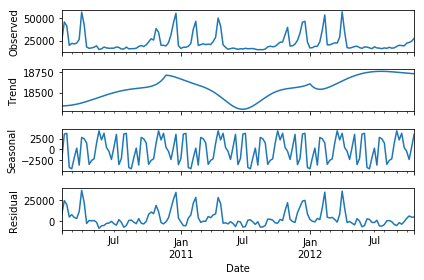

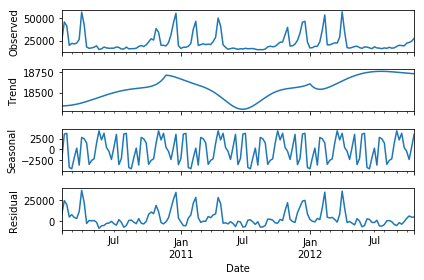

In [56]:
# plt.figure(figsize=(15,6))
decomp.plot()

## Forecast

In [78]:
drift?

In [63]:
fcast = forecast(decomp, steps=24, fc_func=drift, seasonal=True)

In [80]:
store_11_ts.tail(10)

Date
2012-08-24    16286.40
2012-08-31    16680.24
2012-09-07    18322.37
2012-09-14    19616.22
2012-09-21    19251.50
2012-09-28    18947.81
2012-10-05    21904.47
2012-10-12    22764.01
2012-10-19    24185.27
2012-10-26    27390.81
Name: Weekly_Sales, dtype: float64

In [64]:
fcast

,drift+seasonal
2012-11-02,15245.719362
2012-11-09,16636.438475
2012-11-16,22260.192311
2012-11-23,22433.633641
2012-11-30,14581.057347
2012-12-07,14280.628015
2012-12-14,16791.229760
2012-12-21,19030.119721
2012-12-28,15120.468001
2013-01-04,21484.894913


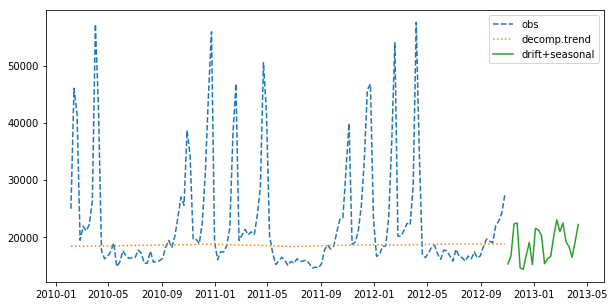

In [65]:
plt.figure(figsize=(10,5))
plt.plot(store_11_ts, '--', label='obs')
plt.plot(decomp.trend, ':', label='decomp.trend')
plt.plot(fcast,'-', label = fcast.columns[0])

plt.legend()

In [52]:
len(store_11_ts.iloc[30:87])#.plot(kind='line')

57

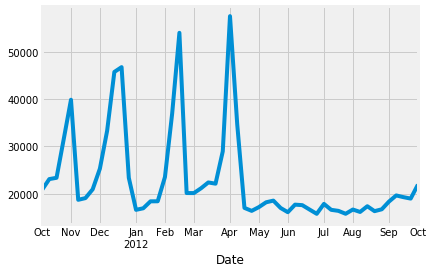

In [51]:
store_11_ts.iloc[87:140].plot(kind='line')

### ETS Models (Exponential Smoothening Models)

### Single Exponential Smoothing
Single Exponential Smoothing or simple smoothing can be implemented in Python via the SimpleExpSmoothing Statsmodels class.

First, an instance of the SimpleExpSmoothing class must be instantiated and passed the training data. The fit() function is then called providing the fit configuration, specifically the alpha value called smoothing_level. If this is not provided or set to None, the model will automatically optimize the value.

This fit() function returns an instance of the HoltWintersResults class that contains the learned coefficients. The forecast() or the predict() function on the result object can be called to make a forecast.

In [53]:
### single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.1
beta = 0.2
gamma = 0.02

# initialise model
ets_model = ExponentialSmoothing(store_11_ts, trend='add', seasonal='add', seasonal_periods=52)
ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

In [54]:
# forecast p months ahead
p_ahead = 24
yh = ets_fit.forecast(p_ahead)

In [55]:
yh

2012-11-02    32027.545479
2012-11-09    16789.994922
2012-11-16    16396.319021
2012-11-23    15309.753428
2012-11-30    18607.925823
2012-12-07    27153.348360
2012-12-14    40135.926375
2012-12-21    50542.577958
2012-12-28    13615.696921
2013-01-04     9984.119147
2013-01-11    10928.285864
2013-01-18    10532.121290
2013-01-25    11218.724245
2013-02-01    17183.408813
2013-02-08    37652.710561
2013-02-15    33535.293541
2013-02-22    10557.827186
2013-03-01    12495.500567
2013-03-08    11381.402770
2013-03-15    12029.902385
2013-03-22    15563.059724
2013-03-29    45107.131419
2013-04-05    31764.767914
2013-04-12     6653.925402
Freq: W-FRI, dtype: float64

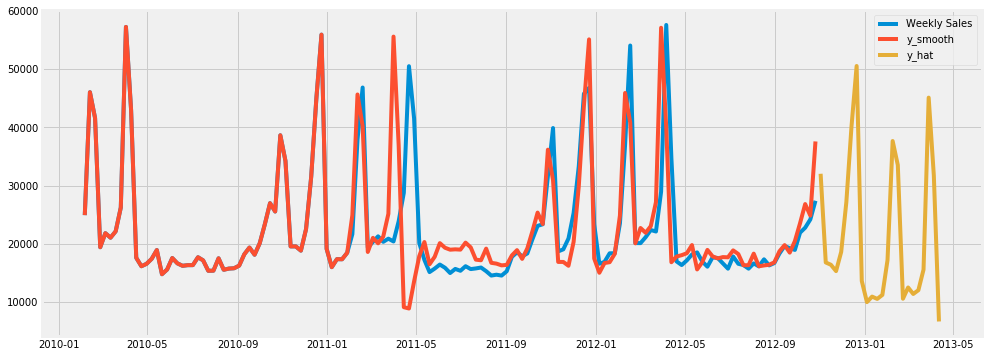

In [56]:
# plot the y, y_smoothed and y_hat ts'
plt.figure(figsize=(15,6))
plt.plot(store_11_ts, label='Weekly Sales')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat')

plt.legend()
plt.show()

### Dickey-Fuller Test 
- Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [57]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [58]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(store_11_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.522164
p-value                          0.110174
#lags Used                       6.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


##### Now store _11 has p-value 0.11 which is more than 0.05, null hypothesis is accepted and this is a  random walk.

In [59]:
store_11_ts_log = np.log10(store_11_ts)

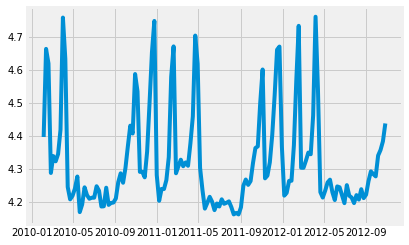

In [60]:
plt.plot(store_11_ts_log)

In [61]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(store_11_ts_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.061511
p-value                          0.029536
#lags Used                      10.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


The following are some of our key observations from this analysis:
1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

- Seasonalityt×Remaindert=YtTrendt

 
3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

- Remaindert=YtTrendt×Seasonalityt
 
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

#### ARIMA Modeling
ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

1st Pass of ARIMA to Extract Juice / Information
Integrated (I) – subtract time series with its lagged series to extract trends from the data
In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for different orders of differencing are as follow:

- No Differencing (d=0) |  Y′t=YtYt′=Yt 
- 1st Differencing (d=1) |  Y′t=Yt−Yt−1Yt′=Yt−Yt−1 
- 2nd Differencing (d=1) |  Y′t=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2Yt′=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2 

For example, in the below plot a time series data with a linearly upward trend is displayed. Adjacent to that plot is the 1st order differenced plot for the same data. As we can notice after 1st order differencing, trend part of the series is extracted and the difference data (residual) does not display any trend.

#### Step 2: Difference data to make data stationary on mean (remove trend)
Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) |  Y′t=Yt−Yt−1

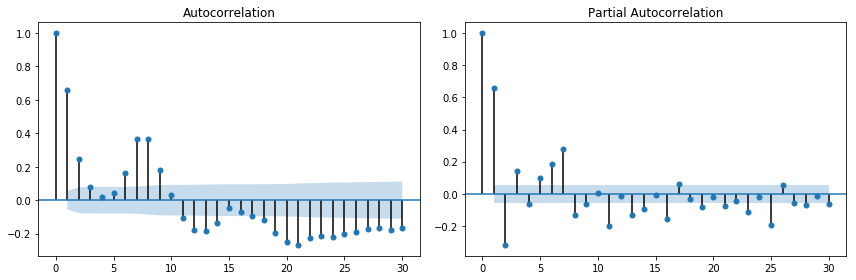

In [126]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(store_11_ts_log, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(store_11_ts_log, lags=30, ax=axes[1], alpha=0.5, method='ols')
plt.tight_layout()

## Implementation of SARIMA MODEL
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

In [20]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

In [62]:
model = sm.tsa.statespace.SARIMAX(store_11_ts_log, order = (1,2,1), seasonal_order= (1,0,0,52),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

In [63]:
results = model.fit()

In [64]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 2, 1)x(1, 0, 0, 52)   Log Likelihood                  73.570
Date:                            Mon, 12 Aug 2019   AIC                           -139.141
Time:                                    11:54:17   BIC                           -129.232
Sample:                                02-05-2010   HQIC                          -135.149
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1670      0.098      1.708      0.088      -0.025       0.359
ma.L1         -1.0000    389.894   

In [65]:
np.power(10, results.forecast(steps=36))

2012-11-02    30330.710089
2012-11-09    21439.421693
2012-11-16    21574.114343
2012-11-23    22453.005333
2012-11-30    24421.068817
2012-12-07    27606.136346
2012-12-14    31818.703938
2012-12-21    32061.018869
2012-12-28    23327.490528
2013-01-04    19913.573831
2013-01-11    20043.186310
2013-01-18    20768.040802
2013-01-25    20725.348944
2013-02-01    23122.891210
2013-02-08    28338.988168
2013-02-15    33588.965377
2013-02-22    21392.768413
2013-03-01    21336.511220
2013-03-08    21772.684752
2013-03-15    22284.554665
2013-03-22    22114.204112
2013-03-29    24936.669305
2013-04-05    33997.103311
2013-04-12    26939.728612
2013-04-19    19428.753376
2013-04-26    19053.268509
2013-05-03    19424.809839
2013-05-10    19892.253799
2013-05-17    20019.467905
2013-05-24    19192.370411
2013-05-31    18679.566744
2013-06-07    19456.440546
2013-06-14    19356.608866
2013-06-21    18841.559061
2013-06-28    18322.256394
2013-07-05    19349.823475
Freq: W-FRI, dtype: float64

### Iterate the process to find the best values for p, d, q and P, D, Q

In [133]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(2,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 48) for x in list(itertools.product(P, D, Q))]

display(seasonal_pdq)
display(pdq)

[(0, 0, 0, 48),
 (0, 0, 1, 48),
 (0, 1, 0, 48),
 (0, 1, 1, 48),
 (1, 0, 0, 48),
 (1, 0, 1, 48),
 (1, 1, 0, 48),
 (1, 1, 1, 48)]

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [134]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(store_11_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(2, 2, 2)x(0, 0, 0, 48)12 model - AIC:-214.5985746796182


#### Step 7: Predict sales on in-sample date using the best fit ARIMA model
The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [136]:
best_model = sm.tsa.statespace.SARIMAX(store_11_ts_log,
                                      order=(2, 2, 2),
                                      seasonal_order=(0, 0, 0, 48),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [137]:
print(best_results.summary())
# print(best_results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(2, 2, 2)   Log Likelihood                 112.299
Date:                Mon, 12 Aug 2019   AIC                           -214.599
Time:                        13:08:48   BIC                           -199.962
Sample:                    02-05-2010   HQIC                          -208.651
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7313      0.084      8.688      0.000       0.566       0.896
ar.L2         -0.3974      0.072     -5.518      0.000      -0.539      -0.256
ma.L1         -1.7764     36.911     -0.048      0.9

In [138]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2010-09-03'), full_results=True)

In [79]:
pred_dynamic.predicted_mean

2010-09-03    4.181394
2010-09-10    4.192077
2010-09-17    4.236337
2010-09-24    4.245289
2010-10-01    4.213125
2010-10-08    4.277045
2010-10-15    4.328394
2010-10-22    4.371956
2010-10-29    4.337615
2010-11-05    4.541669
2010-11-12    4.430695
2010-11-19    4.238540
2010-11-26    4.348385
2010-12-03    4.317524
2010-12-10    4.389454
2010-12-17    4.492283
2010-12-24    4.587735
2010-12-31    4.637700
2011-01-07    4.172426
2011-01-14    4.308762
2011-01-21    4.349218
2011-01-28    4.307433
2011-02-04    4.316805
2011-02-11    4.360811
2011-02-18    4.563688
2011-02-25    4.561436
2011-03-04    4.177917
2011-03-11    4.377368
2011-03-18    4.371768
2011-03-25    4.333991
                ...   
2012-04-06    4.471286
2012-04-13    4.710760
2012-04-20    4.392055
2012-04-27    4.215297
2012-05-04    4.326289
2012-05-11    4.326627
2012-05-18    4.320895
2012-05-25    4.304444
2012-06-01    4.255509
2012-06-08    4.241337
2012-06-15    4.281648
2012-06-22    4.254117
2012-06-29 

In [80]:
np.power(10, pred_dynamic.predicted_mean)

2010-09-03    15184.266427
2010-09-10    15562.432855
2010-09-17    17232.033554
2010-09-24    17590.943507
2010-10-01    16335.225397
2010-10-08    18925.392808
2010-10-15    21300.686300
2010-10-22    23548.107941
2010-10-29    21757.817878
2010-11-05    34807.206233
2010-11-12    26958.461469
2010-11-19    17319.698521
2010-11-26    22304.130788
2010-12-03    20774.207180
2010-12-10    24516.263454
2010-12-17    31065.852065
2010-12-24    38702.164992
2010-12-31    43420.971741
2011-01-07    14873.950569
2011-01-14    20359.237194
2011-01-21    22346.923574
2011-01-28    20297.063115
2011-02-04    20739.818889
2011-02-11    22951.473816
2011-02-18    36617.430406
2011-02-25    36428.085423
2011-03-04    15063.199530
2011-03-11    23843.399816
2011-03-18    23537.923162
2011-03-25    21577.010420
                  ...     
2012-04-06    29599.609678
2012-04-13    51375.913915
2012-04-20    24663.489009
2012-04-27    16417.139885
2012-05-04    21197.720420
2012-05-11    21214.194227
2

In [139]:
forecast = np.power(10,pred_dynamic.predicted_mean)

In [140]:
actual = store_11_ts['2010-09-03':]

In [141]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [142]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))


The Mean Absolute percentage error of our forecast for last two years is 0.1857


In [143]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 56701277.9791
The ROOT Mean Squared Error of our forecasts is 7530.025098171984


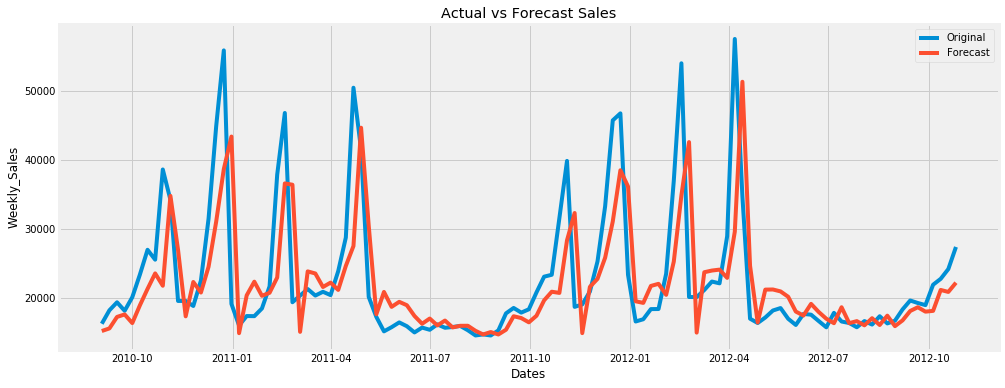

In [144]:
plt.figure(figsize=(15,6))
plt.plot(actual.index, actual, label='Original')
plt.plot(forecast.index, forecast, label='Forecast')
plt.xlabel("Dates")
plt.ylabel("Weekly_Sales")
plt.title("Actual vs Forecast Sales")
plt.legend()

Text(0.5, 1.0, 'Error Plot')

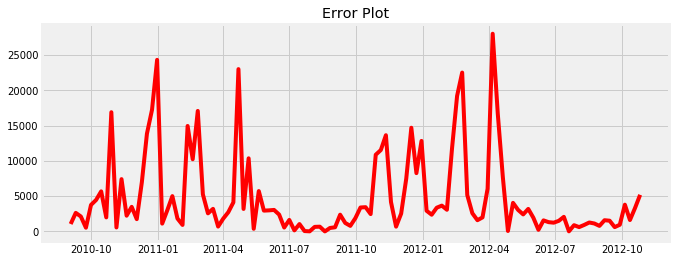

In [145]:
Error = np.abs(actual - forecast)
plt.figure(figsize=(10,4))
plt.plot(Error.index, Error, color='r')
plt.title('Error Plot')

#### Step 8: Forecast sales using the best fit SARIMA model

In [107]:
test[(test.Store==1) & (test.Dept==1)]

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
5,1,1,2012-12-07,False
6,1,1,2012-12-14,False
7,1,1,2012-12-21,False
8,1,1,2012-12-28,True
9,1,1,2013-01-04,False


In [146]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-11-02'), end=pd.to_datetime('2013-07-26'),full_results=True)
forecast = np.power(10,pred_dynamic.predicted_mean)

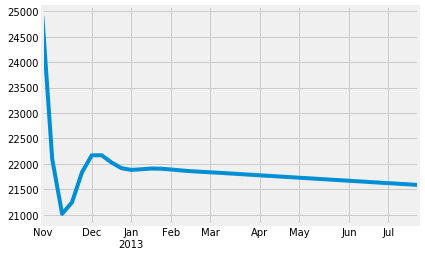

In [147]:
forecast.plot(kind='line')

In [112]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 39
pred_uc_99 = best_results.get_forecast(steps=39, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=39, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [113]:
pred_ci_99.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,4.190722,4.601707
2012-11-09,4.059118,4.629499
2012-11-16,4.016700,4.628580
2012-11-23,4.017188,4.637336
2012-11-30,4.026284,4.651905


In [114]:
pred_ci_95.tail()

,lower Weekly_Sales,upper Weekly_Sales
2013-06-28,3.796926,4.873349
2013-07-05,3.789768,4.880033
2013-07-12,3.782632,4.886695
2013-07-19,3.775518,4.893335
2013-07-26,3.768425,4.899954


In [119]:
pred_ci_95.index

DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18',
               '2013-01-25', '2013-02-01', '2013-02-08', '2013-02-15',
               '2013-02-22', '2013-03-01', '2013-03-08', '2013-03-15',
               '2013-03-22', '2013-03-29', '2013-04-05', '2013-04-12',
               '2013-04-19', '2013-04-26', '2013-05-03', '2013-05-10',
               '2013-05-17', '2013-05-24', '2013-05-31', '2013-06-07',
               '2013-06-14', '2013-06-21', '2013-06-28', '2013-07-05',
               '2013-07-12', '2013-07-19', '2013-07-26'],
              dtype='datetime64[ns]', freq='W-FRI')

In [120]:
n_steps = 39
idx = pred_ci_95.index
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [121]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2012-11-02,24900.853719,15513.922612,39967.488006
2012-11-09,22095.744177,11458.249477,42608.769491
2012-11-16,21020.359855,10392.032370,42518.682846
2012-11-23,21245.258033,10403.711815,43384.610892
2012-11-30,21832.046119,10623.896604,44864.728592


In [122]:
fc_99.head()

,lower_ci_99,upper_ci_99
2012-11-02,15513.922612,39967.488006
2012-11-09,11458.249477,42608.769491
2012-11-16,10392.032370,42518.682846
2012-11-23,10403.711815,43384.610892
2012-11-30,10623.896604,44864.728592


In [123]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2012-11-02,24900.853719,15513.922612,39967.488006,15513.922612,39967.488006
2012-11-09,22095.744177,11458.249477,42608.769491,11458.249477,42608.769491
2012-11-16,21020.359855,10392.032370,42518.682846,10392.032370,42518.682846
2012-11-23,21245.258033,10403.711815,43384.610892,10403.711815,43384.610892
2012-11-30,21832.046119,10623.896604,44864.728592,10623.896604,44864.728592


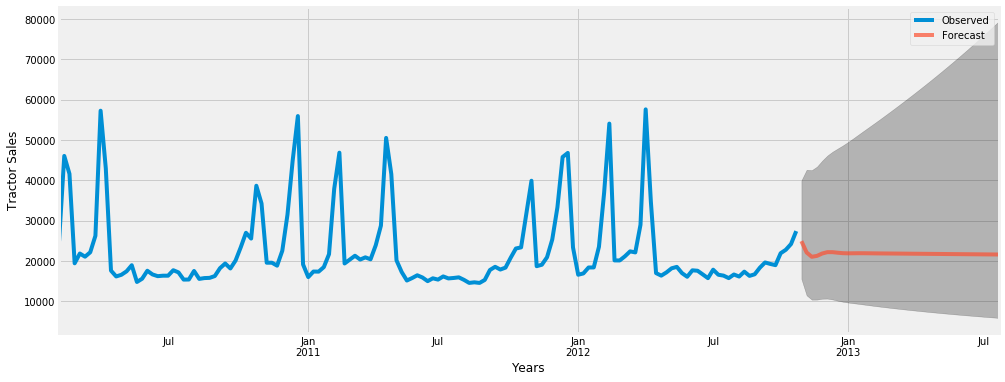

In [125]:
# plot the forecast along with the confidence band
axis = store_11_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [131]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)

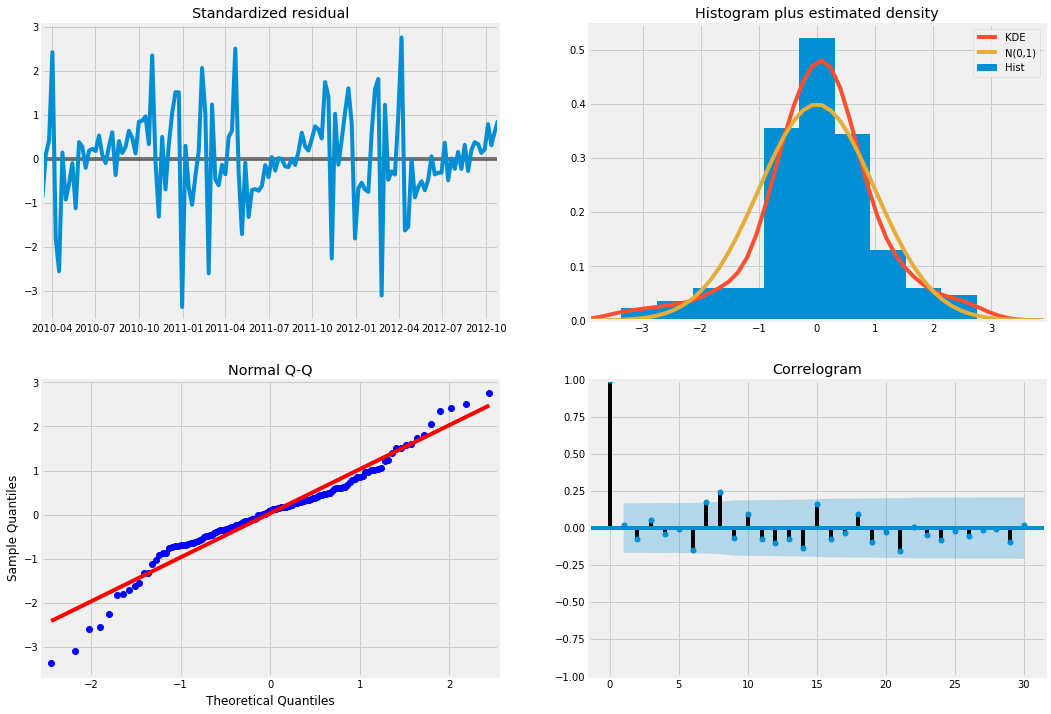

In [132]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:
- The KDE plot of the residuals on the top right is almost similar with the normal distribution.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.